In [1]:
#======Core============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import EarlyStopping
import torch
#======Darts===========
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts.dataprocessing import Pipeline
#======UEXP============
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
#from ue.uexp.dataprocessing.ta import *
#from ue.uexp.models.util import *
#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta

import warnings
warnings.filterwarnings('ignore')

# Data Processing

In [2]:
# TODO

In [3]:
def py_fc_prep_data(start_date, end_date, interval='1s', tickers=["BTCUSDT"], version="full"):
    """
    using the processor gets data and saves to cache/{fname}.csv, used for forecasting models
    
    args:
        - start_date: str
        - end_date: str
    
    returns:
        - dict: {
        time_idx:
        target
        categorical_encoders
        group_ids:
        time_varying_unknown_reals
        }
    """
    data_path = "{start}-{end}-of-{tics}-{version}-{interval}.csv".format(
        start=start_date,
        end=end_date,
        tics="_".join(tickers),
        version=version,
        interval=interval,
    )
    #check if saved
    if os.path.exists(os.path.join("cache",data_path)):
        return pd.read_csv(data_path)
    
    p = BinanceProcessor("binance")
    df = p.download_data(tickers, start_date, end_date, interval)
    df.columns = ["Open","High","Low","Close","Volume", "Tic"]
    
    if version == "full":
        # see doc for details of full
        # https://docs.google.com/document/d/1oo-EgHCVQyvjKiC8cAocfwpZzRHSXDr3YCZJ-agoFv4/edit?usp=sharing
        
        # Relative Strength Index (RSI)
        df["momentum_rsi"] = RSIIndicator(
            close=df["Close"], window=14, fillna=True
        ).rsi()/100 #scale 0-1
        
        # Stoch RSIs (StochRSI)
        indicator_srsi = StochRSIIndicator(
            close=df["Close"], window=14, smooth1=3, smooth2=3, fillna=True
        )
        df["momentum_stoch_rsi"] = indicator_srsi.stochrsi()
        df["momentum_stoch_rsi_k"] = indicator_srsi.stochrsi_k()
        df["momentum_stoch_rsi_d"] = indicator_srsi.stochrsi_d()
        
        # TSI Indicator
        df["momentum_tsi"] = TSIIndicator(
            close=df["Close"], window_slow=25, window_fast=13, fillna=True
        ).tsi()/100 #scale 0-1

        # Chaikin Money Flow
        df["volume_cmf"] = ChaikinMoneyFlowIndicator(
            high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
        ).chaikin_money_flow()

        # Money Flow Index
        df["volume_mfi"] = MFIIndicator(
                    high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
                ).money_flow_index()/100 #norm to 0-1

        # Force Index
        df["volume_fi"] = ForceIndexIndicator(
            close=df["Close"], volume=df["Volume"], window=13, fillna=True
        ).force_index()

        # Volume Weighted Average Price
        df["volume_vwap"] = VolumeWeightedAveragePrice(
            high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True,
            window=14,
        ).volume_weighted_average_price()
        
        # MACD
        indicator_macd = MACD(
            close=df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True
        )
        df["trend_macd"] = indicator_macd.macd()
        df["trend_macd_signal"] = indicator_macd.macd_signal()
        df["trend_macd_diff"] = indicator_macd.macd_diff()

        # SMAs
        df["trend_sma_fast"] = SMAIndicator(
            close=df["Close"], window=12, fillna=True
        ).sma_indicator()
        df["trend_sma_slow"] = SMAIndicator(
            close=df["Close"], window=26, fillna=True
        ).sma_indicator()

        # EMAs
        df["trend_ema_fast"] = EMAIndicator(
            close=df["Close"], window=12, fillna=True
        ).ema_indicator()
        df["trend_ema_slow"] = EMAIndicator(
            close=df["Close"], window=26, fillna=True
        ).ema_indicator()
        
        def stationize(series):
            return np.log(series / series.shift(1))
        
        #Turn price into logrets 
        df['log_ret'] = stationize(df['Close'])
        df['log_volume_vwap_ret'] = stationize(df['volume_vwap'])
        df['log_trend_sma_slow_ret'] = stationize(df['trend_sma_slow'])
        df['log_trend_sma_fast_ret'] = stationize(df['trend_sma_fast'])
        df['log_trend_ema_slow_ret'] = stationize(df['trend_ema_slow'])
        df['log_trend_ema_fast_ret'] = stationize(df['trend_ema_fast'])
        
        #Build time_idx, series for all series
        df.reset_index(inplace=True)
        df.rename(columns={'index':'time'}, inplace=True)
        df['time_idx'] = df.index
        
        #df['series'] = np.NaN #... is this the best way to handle this...?
        
        #Save to csv
        #df.to_csv(os.path.join("cache",data_path))
        return df
    else:
        #default to OHLCV
        pass

In [4]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2021-12-30"
end_date = "2021-12-31"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-29.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-30.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-31.csv


In [5]:
# for non 1m data
#df.drop(["tic", "adj_close"], axis=1, inplace=True)

In [6]:
df.drop("tic", axis=1, inplace=True)

In [7]:
df.columns = ["Open","High","Low","Close","Volume"]


In [8]:
df.head()

,Open,High,Low,Close,Volume
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262


In [9]:
def stationize(series):
    return np.log(series / series.shift(1))

In [10]:
# Log return
df['log_ret'] = stationize(df['Close'])

In [11]:
# Relative Strength Index (RSI)
df["momentum_rsi"] = RSIIndicator(
close=df["Close"], window=14, fillna=True
).rsi()/100 #scale 0-1

# Stoch RSIs (StochRSI)
indicator_srsi = StochRSIIndicator(
close=df["Close"], window=14, smooth1=3, smooth2=3, fillna=True
)
df["momentum_stoch_rsi"] = indicator_srsi.stochrsi()

In [12]:
# Money Flow Index
df["volume_mfi"] = MFIIndicator(
            high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
        ).money_flow_index()/100 #norm to 0-1

In [13]:
# SMAs
df["trend_sma_fast"] = SMAIndicator(
    close=df["Close"], window=12, fillna=True
).sma_indicator()
# EMAs
df["trend_ema_fast"] = EMAIndicator(
    close=df["Close"], window=12, fillna=True
).ema_indicator()

In [14]:
N = 30
df.drop(index=df.index[:N], 
        axis=0, 
        inplace=True)
df.dropna(inplace=True)

In [15]:
# # non 1s specific code
# df['Time'] = pd.to_datetime(df['Time'])
# df.set_index('Time', inplace=True)

In [16]:
# df.asfreq('min')

In [17]:
df.head(50)

,Open,High,Low,Close,Volume,log_ret,momentum_rsi,momentum_stoch_rsi,volume_mfi,trend_sma_fast,trend_ema_fast
2021-12-30 00:00:30,46489.34,46491.32,46489.33,46491.32,0.33023,4.258950e-05,0.720308,5.745188e-01,0.842264,46488.235000,46486.750796
2021-12-30 00:00:31,46491.32,46493.97,46491.31,46491.31,0.50273,-2.150939e-07,0.720075,5.738897e-01,0.848999,46490.484167,46487.452212
2021-12-30 00:00:32,46491.31,46491.32,46491.31,46491.32,0.16562,2.150939e-07,0.720172,4.113943e-01,0.836165,46491.430000,46488.047256
2021-12-30 00:00:33,46491.32,46493.96,46491.32,46491.41,0.16494,1.935843e-06,0.721114,1.055475e-01,0.830981,46492.383333,46488.564601
2021-12-30 00:00:34,46492.43,46492.47,46492.43,46492.47,0.29916,2.279965e-05,0.732532,1.706610e-01,0.656490,46493.424167,46489.165432
2021-12-30 00:00:35,46492.47,46500.00,46492.47,46494.24,1.41223,3.806996e-05,0.750872,2.752578e-01,0.725291,46493.250833,46489.946135
2021-12-30 00:00:36,46494.25,46497.97,46494.24,46497.97,0.10976,8.022177e-05,0.784421,4.665834e-01,0.728409,46493.387500,46491.180576
2021-12-30 00:00:37,46499.97,46500.00,46499.97,46499.99,0.07930,4.344181e-05,0.800119,5.561096e-01,0.713506,46493.693333,46492.535872
2021-12-30 00:00:38,46499.99,46499.99,46497.81,46497.82,0.36357,-4.666777e-05,0.737952,2.018492e-01,0.554178,46493.930000,46493.348814
2021-12-30 00:00:39,46497.82,46497.82,46497.81,46497.82,0.26512,0.000000e+00,0.737952,2.496731e-01,0.558277,46494.166667,46494.036689


In [18]:
dfts = TimeSeries.from_dataframe(df)

[2022-02-22 03:30:27,140] WARNING | darts.timeseries | Number of components is larger than 10 (11). Plotting only the first 10 components.


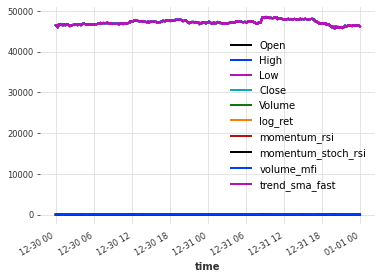

In [19]:
dfts.plot()

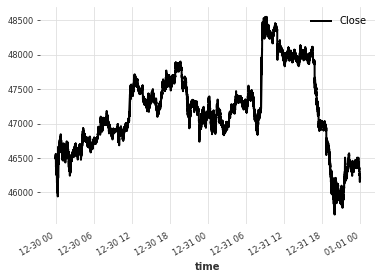

In [20]:
dfts['Close'].plot()

In [21]:
dfts.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'log_ret', 'momentum_rsi',
       'momentum_stoch_rsi', 'volume_mfi', 'trend_sma_fast', 'trend_ema_fast'],
      dtype='object', name='component')

## Processing multiple TS

In [22]:
# Train set
train_df = dfts[:int(0.8*df.shape[0])]

In [23]:
scaler_target_tr = Scaler()
# [0] because singular
scaled_target = scaler_target_tr.fit_transform(train_df['Close'])

In [24]:
cov_ts = [train_df['Open'], train_df['High'], train_df['Volume'], 
               train_df['log_ret'], train_df['trend_sma_fast'], train_df['trend_ema_fast']]
# the other indicators are already scaled

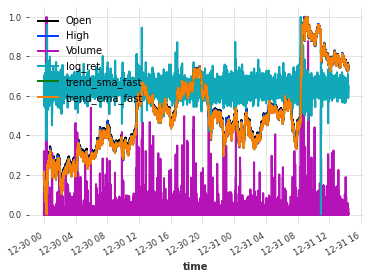

In [25]:
scaler_cov_tr = Scaler()
pipeline_train = Pipeline([scaler_cov_tr])
transformed_train = pipeline_train.fit_transform(cov_ts)

for ts in transformed_train:
    ts.plot()

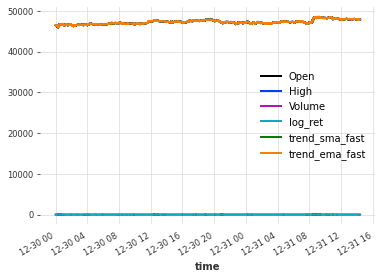

In [26]:
# back transform (sanity check)
back_train = pipeline_train.inverse_transform(transformed_train, partial=True)
for ts in back_train:
    ts.plot()

In [27]:
# Val set
val_df = dfts[int(0.8*df.shape[0]):]

In [28]:
scaler_target_val = Scaler()
scaled_val_target = scaler_target_val.fit_transform(val_df['Close'])

In [29]:
multiple_ts_val = [val_df['Open'], val_df['High'], val_df['Volume'], 
               val_df['log_ret'], val_df['trend_sma_fast'], val_df['trend_ema_fast']]
# the other indicators are already scaled

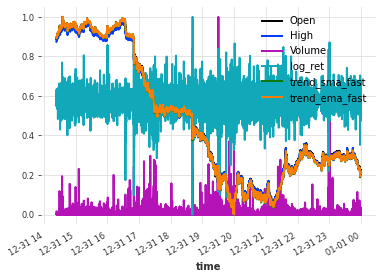

In [30]:
scaler_cov_val = Scaler()
pipeline_val = Pipeline([scaler_cov_val])
transformed_val= pipeline_val.fit_transform(multiple_ts_val)

for ts in transformed_val:
    ts.plot()

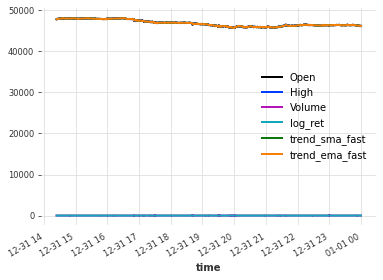

In [31]:
# back transform (sanity check)
back_val = pipeline_val.inverse_transform(transformed_val, partial=True)
for ts in back_val:
    ts.plot()

## Model

In [32]:
model = NBEATSModel(input_chunk_length=60, output_chunk_length=15, random_state=42)

In [33]:
from darts import concatenate

In [34]:
tr_covs = concatenate(transformed_train, axis="component")
val_covs = concatenate(transformed_val, axis="component")

In [35]:
#series = 
model.fit(
    series=scaled_target, 
    past_covariates=tr_covs,
    val_series=scaled_val_target, 
    val_past_covariates=val_covs,
    epochs=50, 
    verbose=True)

[2022-02-22 03:30:33,240] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 138142 samples.
[2022-02-22 03:30:33,240] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 138142 samples.
[2022-02-22 03:30:33,299] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-22 03:30:33,299] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-22 03:30:33,300] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-02-22 03:30:33,300] WARNING | darts.models.forecasting.torch_forecasting_model | D

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [36]:
# training was for horizon=15, if predict here horizon>15 then need historic_future_covs
pred_train = model.predict(series=scaled_target, n=15)

Predicting: 4317it [00:00, ?it/s]

In [37]:
# scale back:
pred_train_scaled = scaler_target_tr.inverse_transform([pred_train])

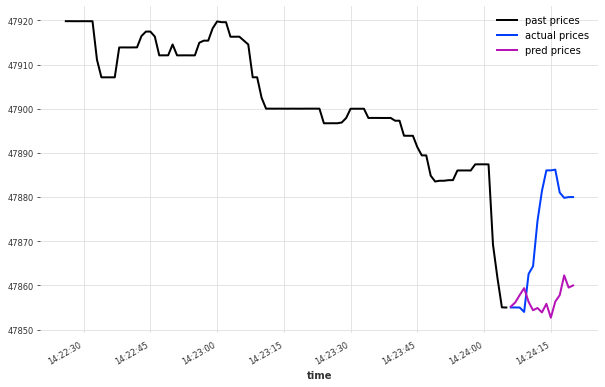

In [41]:
plt.figure(figsize=(10, 6))
# prev train
train_df['Close'][-100:].plot(label="past prices")
#actual
val_df['Close'][:15].plot(label="actual prices")
# pred
pred_train_scaled[0].plot(label="pred prices")

In [46]:
dir(model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_batch_collate_fn',
 '_build_forecast_series',
 '_build_inference_dataset',
 '_build_train_dataset',
 '_create_model',
 '_create_save_dirs',
 '_expect_future_covariates',
 '_expect_past_covariates',
 '_extract_model_creation_params',
 '_extract_pl_module_params',
 '_extract_torch_devices',
 '_extract_torch_model_params',
 '_fit_called',
 '_fit_wrapper',
 '_generate_new_dates',
 '_get_last_prediction_time',
 '_historical_forecasts_sanity_checks',
 '_init_model',
 '_init_trainer',
 '_is_probabilistic',
 '_model_encoder_settings',
 '_model_params',
 '_predict_wrapper',
 '_

In [49]:
model.save_model("overnight.pth.tar")

## Historical Forecast

In [42]:
hist_for = model.historical_forecasts(
    series=train_df['Close'],
    start=0.95, #just the last 1 percent
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)

  0%|          | 0/1382 [00:00<?, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

Predicting: 4317it [00:00, ?it/s]

In [43]:
# rescale
# scale back:
hist_for_scaled = scaler_target_tr.inverse_transform(hist_for)

In [45]:
hist_for_scaled

<TimeSeries (DataArray) (time: 1382, component: 1, sample: 1)>
array([[[35364976.50997275]],

       [[35364393.89486285]],

       [[35354385.36436209]],

       ...,

       [[35295232.78703431]],

       [[35291226.72570521]],

       [[35293600.50657464]]])
Coordinates:
  * time       (time) datetime64[ns] 2021-12-31T12:29:00 ... 2021-12-31T14:24:05
  * component  (component) object '0'
Dimensions without coordinates: sample

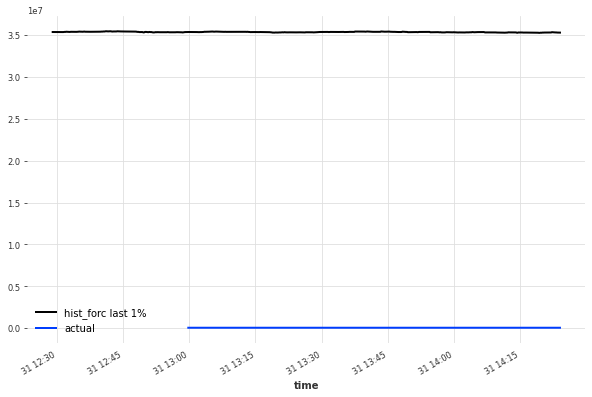

In [44]:
plt.figure(figsize=(10, 6))
hist_for_scaled.plot(label="hist_forc last 1%")
train_df['Close'][-5060:].plot(label="actual")